In [27]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [28]:
# Load dataset
data = pd.read_csv("/content/car data.csv")
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [29]:
# Shape and basic info
print(data.shape)
print(data.info())
print(data.isnull().sum())  # missing values
print(data.duplicated().sum())  # duplicates

# Basic statistics
data.describe()

(301, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None
Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64
2


,Year,Selling_Price,Present_Price,Driven_kms,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.642584,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [30]:
data.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'],
      dtype='object')

In [31]:
# Remove rows where Fuel_Type is CNG
if "Fuel_Type" in data.columns:
    data = data[data["Fuel_Type"] != "CNG"]

print("After removing CNG rows, shape:", data.shape)

# Now check value counts for categorical columns
for col in data.select_dtypes(include=['object']).columns:
    print(f"\nValue counts for {col}:")
    print(data[col].value_counts())

After removing CNG rows, shape: (299, 9)

Value counts for Car_Name:
Car_Name
city                  26
corolla altis         16
verna                 14
fortuner              11
brio                  10
                      ..
Honda Activa 125       1
Hero Hunk              1
Hero  Ignitor Disc     1
Hero  CBZ Xtreme       1
Bajaj  ct 100          1
Name: count, Length: 98, dtype: int64

Value counts for Fuel_Type:
Fuel_Type
Petrol    239
Diesel     60
Name: count, dtype: int64

Value counts for Selling_type:
Selling_type
Dealer        193
Individual    106
Name: count, dtype: int64

Value counts for Transmission:
Transmission
Manual       259
Automatic     40
Name: count, dtype: int64


Before cleaning shape: (299, 9)
After cleaning shape: (281, 9)


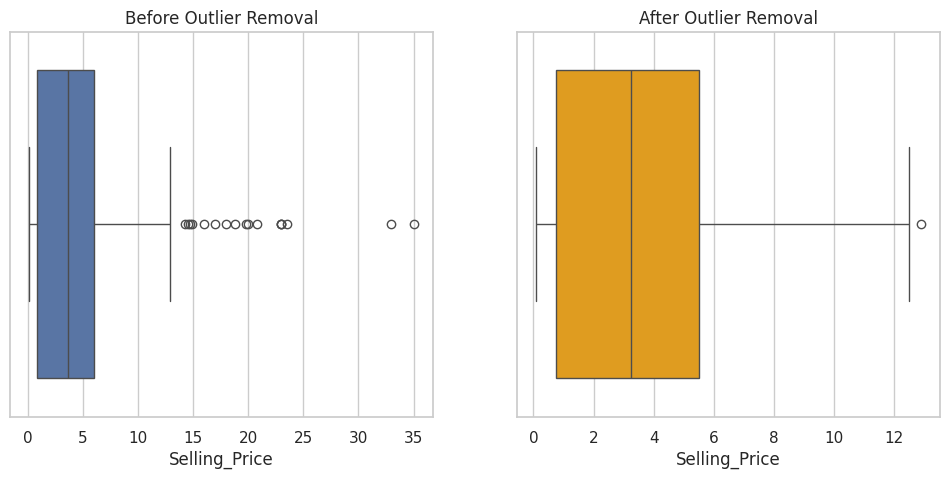

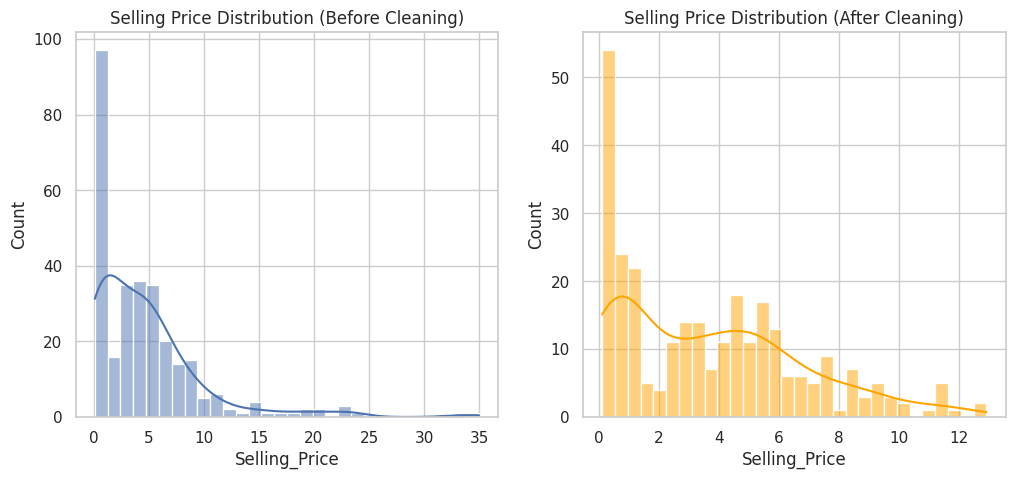

In [32]:
# Remove duplicates
data_after = data.drop_duplicates()

# IQR method
Q1 = data_after['Selling_Price'].quantile(0.25)
Q3 = data_after['Selling_Price'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Remove outliers
data_after = data_after[(data_after['Selling_Price'] >= lower_limit) &
                        (data_after['Selling_Price'] <= upper_limit)]

print("Before cleaning shape:", data.shape)
print("After cleaning shape:", data_after.shape)

# Boxplot before & after
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=data['Selling_Price'])
plt.title("Before Outlier Removal")

plt.subplot(1,2,2)
sns.boxplot(x=data_after['Selling_Price'], color="orange")
plt.title("After Outlier Removal")
plt.show()

# Histogram before & after
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data['Selling_Price'], bins=30, kde=True)
plt.title("Selling Price Distribution (Before Cleaning)")

plt.subplot(1,2,2)
sns.histplot(data_after['Selling_Price'], bins=30, kde=True, color="orange")
plt.title("Selling Price Distribution (After Cleaning)")
plt.show()

In [33]:
# Define target
target = "Selling_Price"

# Drop irrelevant columns if present
drop_cols = []

# Drop Car_Name if exists
if "Car_Name" in data.columns:
    drop_cols.append("Car_Name")

# Convert Year -> Age if exists
import datetime
if "Year" in data.columns:
    current_year = datetime.datetime.now().year
    data["Car_Age"] = current_year - data["Year"]
    drop_cols.append("Year")  # drop raw Year

# Drop Owner
if "Owner" in data.columns:
    drop_cols.append("Owner")

# Apply drops
data = data.drop(columns=drop_cols, errors="ignore")

# Separate features & target
X = data.drop(columns=[target])
y = data[target]

print("Dropped columns:", drop_cols)
print("Features:", X.columns.tolist())
print("Target:", target)

Dropped columns: ['Car_Name', 'Year', 'Owner']
Features: ['Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Car_Age']
Target: Selling_Price


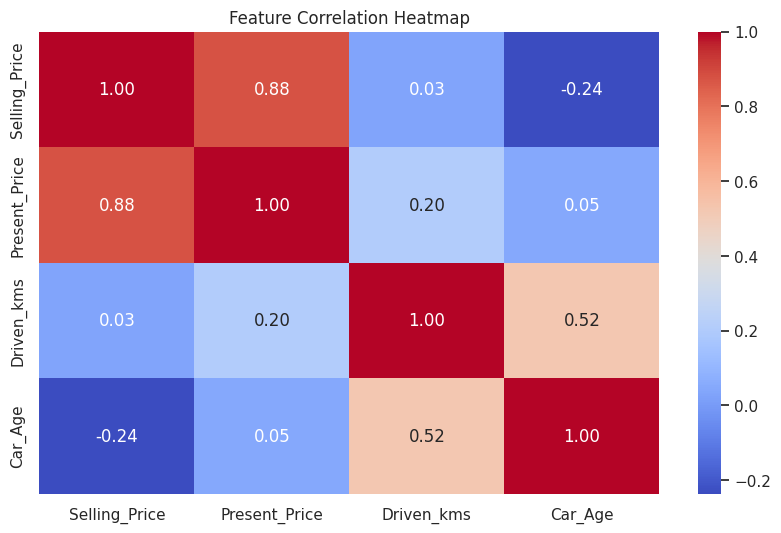

In [34]:
# Correlation heatmap (numerical features only)
plt.figure(figsize=(10,6))
# Select only numeric columns for correlation calculation
numerical_data = data.select_dtypes(include=np.number)
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [35]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

print("Categorical columns encoded successfully.")

Categorical columns encoded successfully.


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (239, 6)
Test shape: (60, 6)


In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling done. X_train and X_test are now standardized.")

Scaling done. X_train and X_test are now standardized.


In [38]:
!pip install lightgbm catboost

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Train-test split (DataFrames)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to NumPy for LightGBM
X_train_np = np.asarray(X_train)
X_test_np  = np.asarray(X_test)
y_train_np = np.ravel(y_train)
y_test_np  = np.ravel(y_test)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=200),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=200),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=200, verbosity=0),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0, n_estimators=200),
}

results = []

for name, model in models.items():
    if name == "LightGBM":
        model.fit(X_train_np, y_train_np)
        y_pred = model.predict(X_test_np)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # ✅ compute RMSE manually
    mae = mean_absolute_error(y_test, y_pred)

    results.append([name, r2, rmse, mae])

# Results as DataFrame
results_df = pd.DataFrame(results, columns=["Model", "R²", "RMSE", "MAE"])

# Sort by R² (best first)
print("Results:")
print(results_df.sort_values(by="R²", ascending=False))

Results:
               Model        R²      RMSE       MAE
4            XGBoost  0.840644  2.374450  0.798483
2      Random Forest  0.814959  2.558659  0.992277
3  Gradient Boosting  0.761589  2.904302  0.943382
5           CatBoost  0.749325  2.978066  0.899433
0  Linear Regression  0.639424  3.571716  1.713458
1      Decision Tree  0.636790  3.584738  1.180667


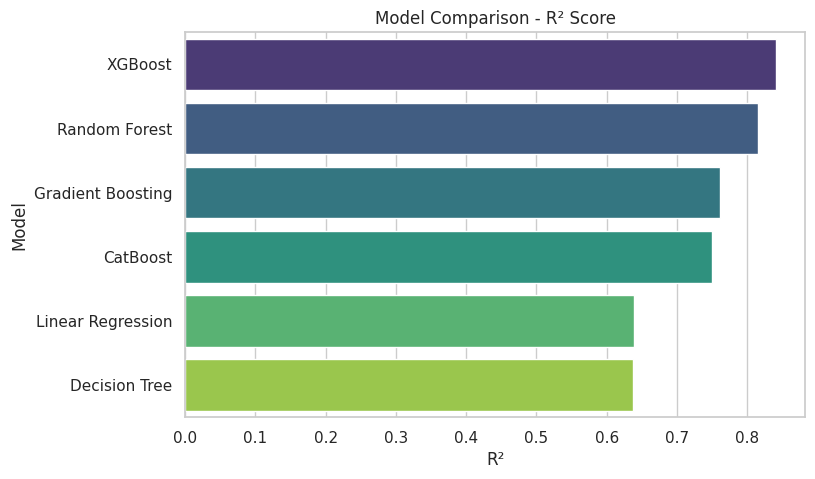

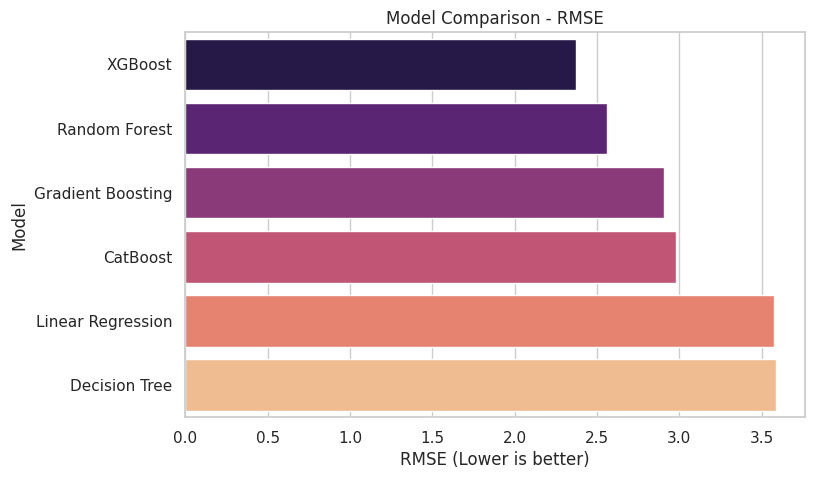

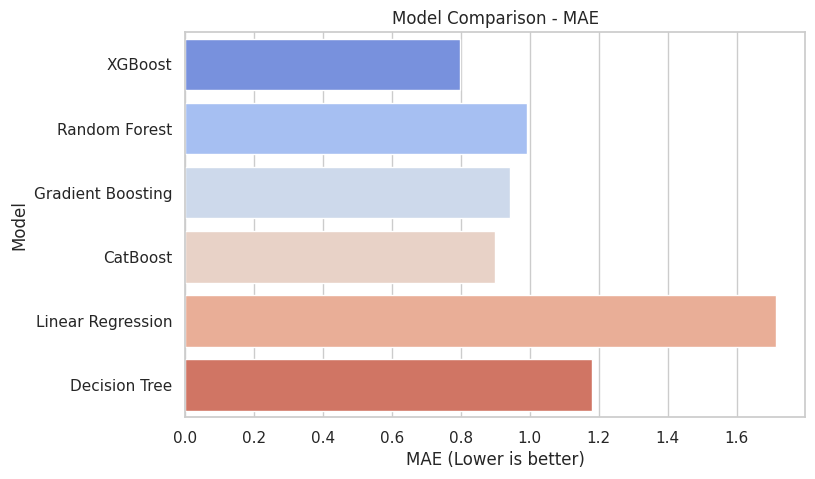

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort results by R²
results_df_sorted = results_df.sort_values(by="R²", ascending=False)

# 1. R² Scores
plt.figure(figsize=(8,5))
sns.barplot(x="R²", y="Model", data=results_df_sorted, palette="viridis", hue="Model", dodge=False, legend=False)
plt.title("Model Comparison - R² Score")
plt.xlabel("R²")
plt.ylabel("Model")
plt.show()

# 2. RMSE
plt.figure(figsize=(8,5))
sns.barplot(x="RMSE", y="Model", data=results_df_sorted, palette="magma", hue="Model", dodge=False, legend=False)
plt.title("Model Comparison - RMSE")
plt.xlabel("RMSE (Lower is better)")
plt.ylabel("Model")
plt.show()

# 3. MAE
plt.figure(figsize=(8,5))
sns.barplot(x="MAE", y="Model", data=results_df_sorted, palette="coolwarm", hue="Model", dodge=False, legend=False)
plt.title("Model Comparison - MAE")
plt.xlabel("MAE (Lower is better)")
plt.ylabel("Model")
plt.show()

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np


# XGBoost Tuning

xgb = XGBRegressor(random_state=42, verbosity=0)

xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,            # number of random combinations to try
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_random.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_random.best_params_)
print("Best XGBoost CV R²:", xgb_random.best_score_)

# Evaluate on test set
best_xgb = xgb_random.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Test R²:", r2_score(y_test, y_pred_xgb))
# print("XGBoost Test RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))
print("XGBoost Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost Test MAE:", mean_absolute_error(y_test, y_pred_xgb))

print("\n" + "-"*30 + "\n")

# Random Forest Tuning

rf = RandomForestRegressor(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,            # number of random combinations
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train, y_train)

print("Best RandomForest Params:", rf_random.best_params_)
print("Best RandomForest CV R²:", rf_random.best_score_)

# Evaluate on test set
best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Test R²:", r2_score(y_test, y_pred_rf))
# print("Random Forest Test RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("Random Forest Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest Test MAE:", mean_absolute_error(y_test, y_pred_rf))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best XGBoost CV R²: 0.9157125737591765
XGBoost Test R²: 0.8417891497380728
XGBoost Test RMSE: 2.3659027126515566
XGBoost Test MAE: 0.790916191255053

------------------------------

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RandomForest Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50}
Best RandomForest CV R²: 0.8958922203036643
Random Forest Test R²: 0.7304494552593862
Random Forest Test RMSE: 3.0881533405837103
Random Forest Test MAE: 1.034380833333333


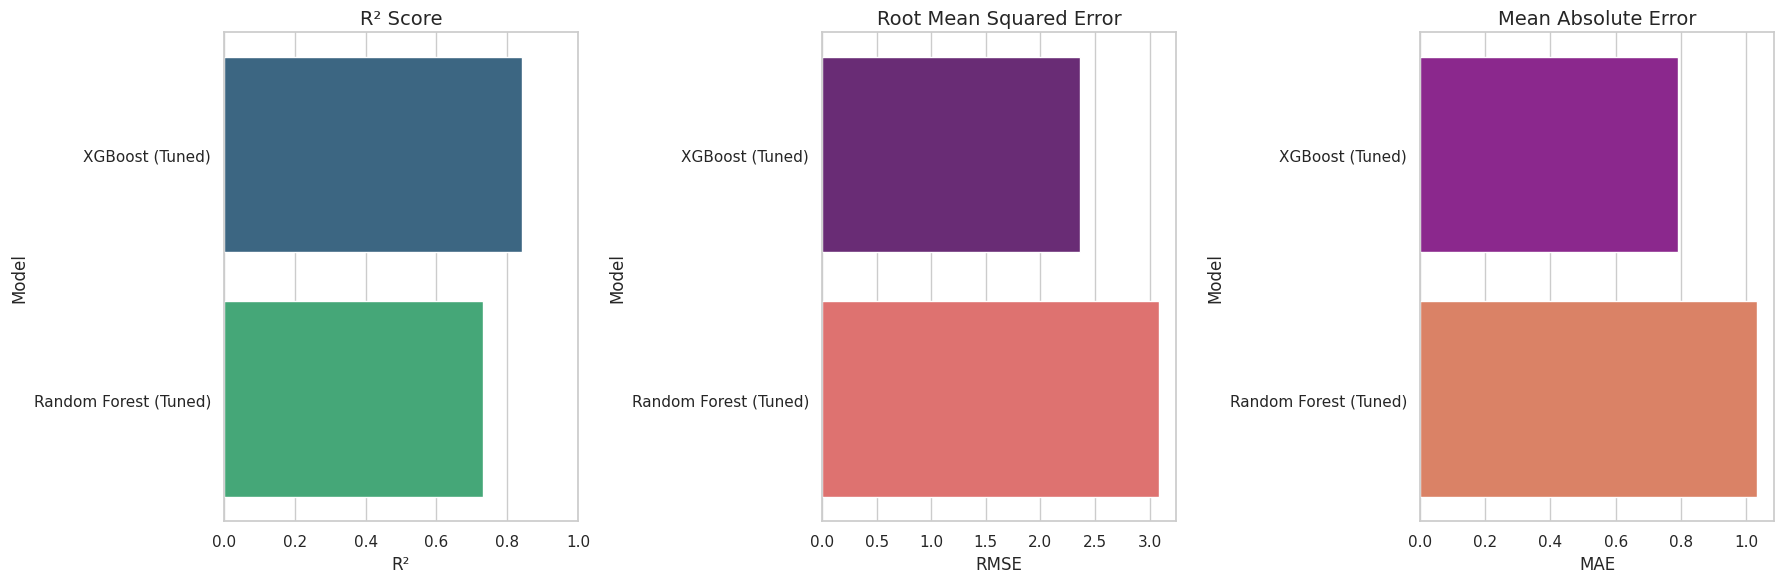

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Store tuned results
tuned_results = pd.DataFrame([
    ["XGBoost (Tuned)", 0.841789, 2.3659, 0.7909],
    ["Random Forest (Tuned)", 0.730449, 3.0881, 1.0343]
], columns=["Model", "R²", "RMSE", "MAE"])

# Set style
sns.set(style="whitegrid", context="notebook")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# R² Plot
sns.barplot(x="R²", y="Model", data=tuned_results,
            palette="viridis", ax=axes[0], hue="Model", dodge=False, legend=False)
axes[0].set_title("R² Score", fontsize=14)
axes[0].set_xlim(0, 1)

# RMSE Plot
sns.barplot(x="RMSE", y="Model", data=tuned_results,
            palette="magma", ax=axes[1], hue="Model", dodge=False, legend=False)
axes[1].set_title("Root Mean Squared Error", fontsize=14)

# MAE Plot
sns.barplot(x="MAE", y="Model", data=tuned_results,
            palette="plasma", ax=axes[2], hue="Model", dodge=False, legend=False)
axes[2].set_title("Mean Absolute Error", fontsize=14)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

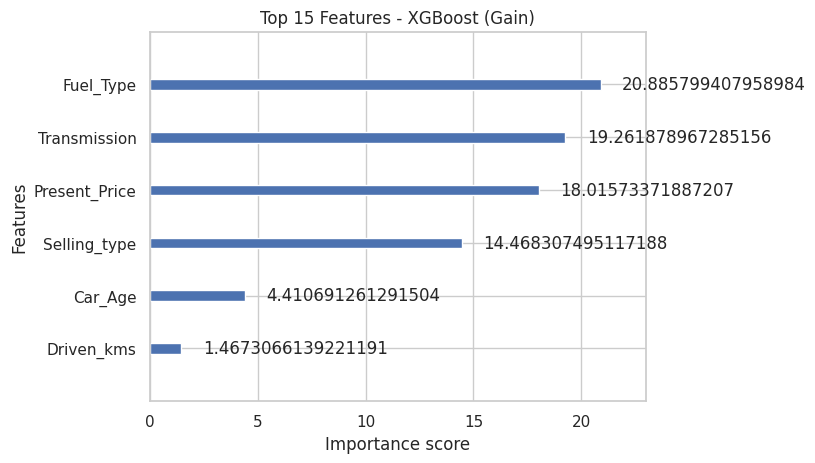

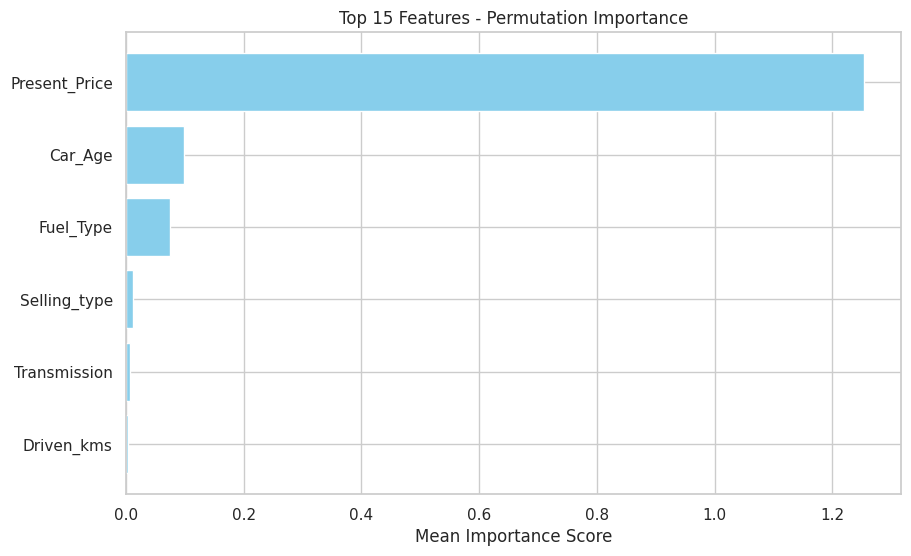

In [44]:
# Step 1: Feature Importance for XGBoost
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import plot_importance

# Train XGBoost again with best params
best_xgb = XGBRegressor(
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    colsample_bytree=0.8,
    random_state=42
)

best_xgb.fit(X_train, y_train)

# --- Feature importance (built-in XGBoost) ---
plt.figure(figsize=(10,6))
plot_importance(best_xgb, importance_type="gain", max_num_features=15)
plt.title("Top 15 Features - XGBoost (Gain)")
plt.show()

# --- Permutation Importance (model-agnostic) ---
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_xgb, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# Barplot
plt.figure(figsize=(10,6))
plt.barh(perm_df["Feature"][:15], perm_df["Importance"][:15], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 15 Features - Permutation Importance")
plt.xlabel("Mean Importance Score")
plt.show()

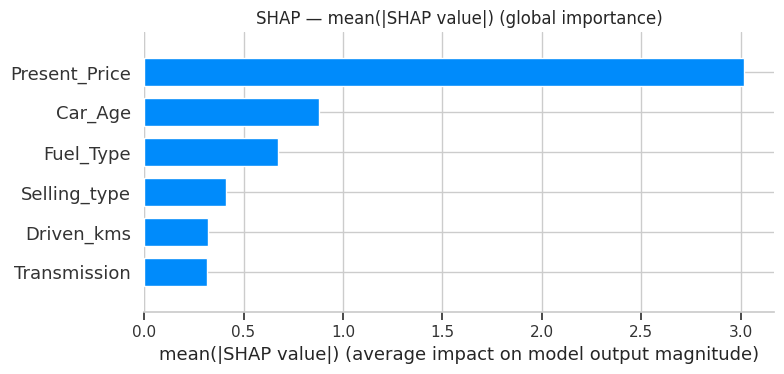

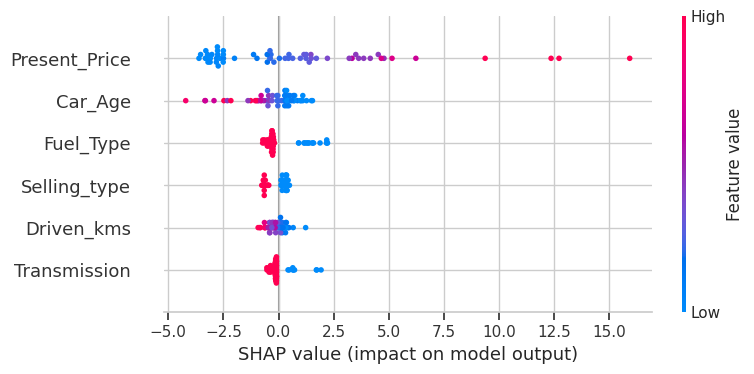

Top SHAP feature: Present_Price


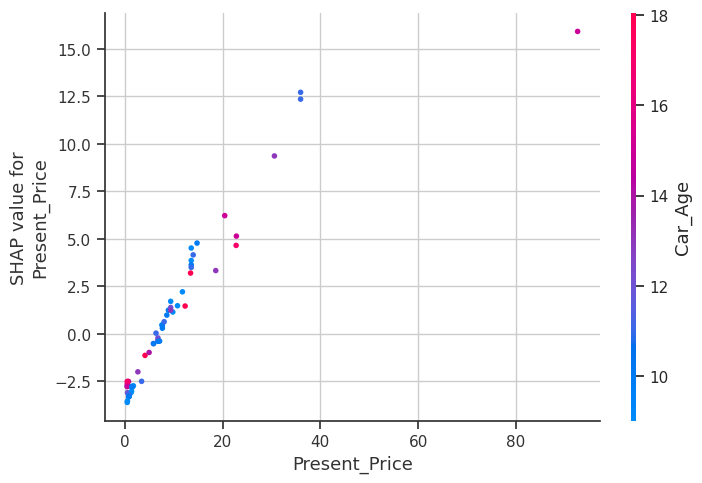

In [45]:
# === Install (run once in Colab) ===
!pip install -q shap

# === SHAP analysis code ===
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# pick the XGBoost model (use existing best_xgb if present)
try:
    model = best_xgb  # from your tuning step
except NameError:
    try:
        model = xgb_random.best_estimator_
    except NameError:
        from xgboost import XGBRegressor
        model = XGBRegressor(subsample=0.8, n_estimators=300, max_depth=5,
                             learning_rate=0.05, colsample_bytree=0.8, random_state=42)
        model.fit(X_train, y_train)

# feature names (handle DataFrame or numpy)
if hasattr(X_train, "columns"):
    feature_names = list(X_train.columns)
else:
    feature_names = [f"f{i}" for i in range(np.asarray(X_train).shape[1])]

# Build a DataFrame copy for SHAP (SHAP likes DataFrames for labeling)
X_test_shap = X_test if hasattr(X_test, "columns") else pd.DataFrame(np.asarray(X_test), columns=feature_names)

# Create TreeExplainer and compute SHAP values (fast for tree models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_shap)  # array: (n_samples, n_features)

# ---- Plots ----
# 1) Bar summary (global importance)
plt.title("SHAP — mean(|SHAP value|) (global importance)")
shap.summary_plot(shap_values, X_test_shap, plot_type="bar", max_display=15, show=False)
plt.tight_layout()
plt.show()

# 2) Beeswarm (detailed global view)
shap.summary_plot(shap_values, X_test_shap, max_display=15, show=False)
plt.tight_layout()
plt.show()

# 3) Dependence plot for the top feature
# find top feature by mean absolute shap
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argmax(mean_abs)
top_feat = X_test_shap.columns[top_idx]
print("Top SHAP feature:", top_feat)
shap.dependence_plot(top_feat, shap_values, X_test_shap, show=False)
plt.tight_layout()
plt.show()

# 4)Local explanation: force plot for the first test sample
# Note: force_plot works best in notebooks with JS; for static export, you can print values instead.
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_shap.iloc[0,:]))

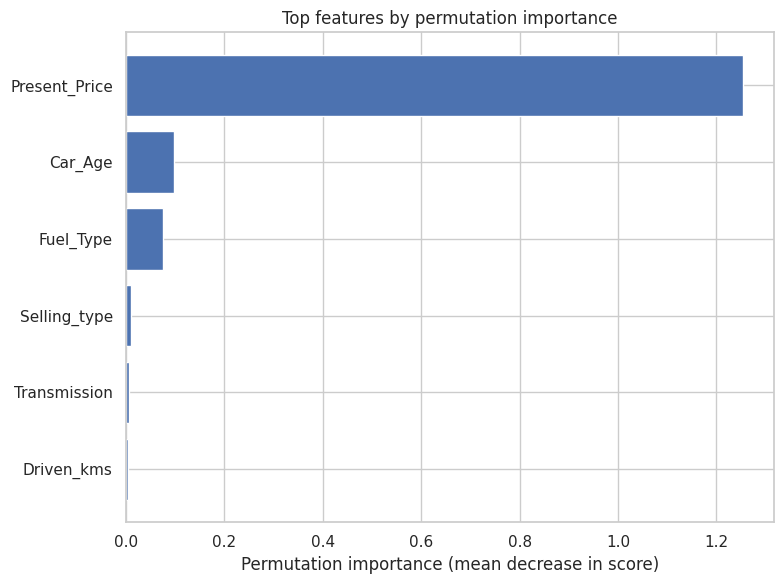

,feature,importance_mean,importance_std
0,Present_Price,1.254203,0.139689
5,Car_Age,0.097631,0.036493
2,Fuel_Type,0.074668,0.013290
3,Selling_type,0.011037,0.003629
4,Transmission,0.006526,0.021231
1,Driven_kms,0.004023,0.009462


In [46]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Choose the model we will explain (reuse variable `model` from SHAP step)
# Use X_test_shap (DataFrame) for names
res = permutation_importance(model, X_test_shap, y_test if not isinstance(y_test, np.ndarray) else np.asarray(y_test),
                             n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    "feature": X_test_shap.columns,
    "importance_mean": res.importances_mean,
    "importance_std": res.importances_std
}).sort_values("importance_mean", ascending=False)

# Plot top 15
topk = min(15, perm_df.shape[0])
plt.figure(figsize=(8,6))
plt.barh(perm_df["feature"].head(topk)[::-1], perm_df["importance_mean"].head(topk)[::-1])
plt.xlabel("Permutation importance (mean decrease in score)")
plt.title("Top features by permutation importance")
plt.tight_layout()
plt.show()

# Print table
display(perm_df.head(20))

CV R² (5-fold): mean = 0.9157, std = 0.0492


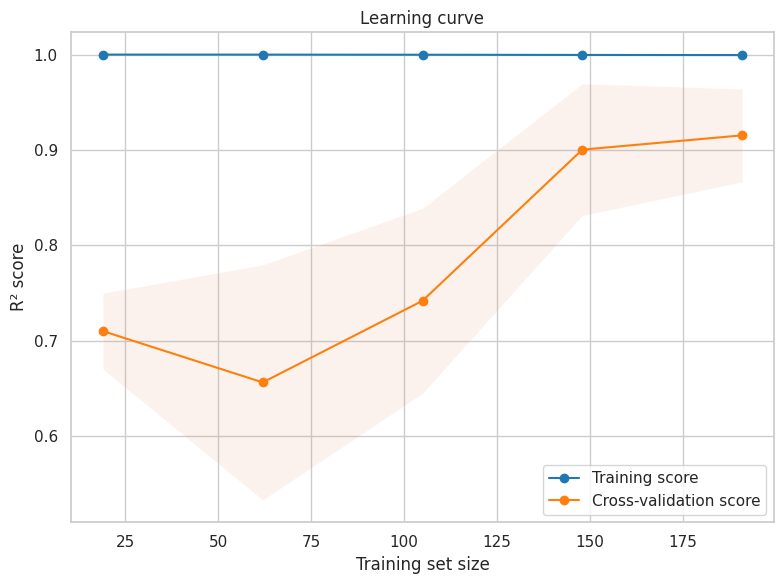

In [47]:
from sklearn.model_selection import cross_val_score, learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Ensure numpy arrays for CV/learning_curve
X_all = X_train if hasattr(X_train, "shape") and hasattr(X_train, "columns") else pd.DataFrame(np.asarray(X_train), columns=feature_names)
y_all = y_train

# Cross-validation on the final model
cv_scores = cross_val_score(model, np.asarray(X_all), np.ravel(y_all), cv=5, scoring='r2', n_jobs=-1)
print("CV R² (5-fold): mean = {:.4f}, std = {:.4f}".format(cv_scores.mean(), cv_scores.std()))

# Learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(model, np.asarray(X_all), np.ravel(y_all),
                                                        cv=5, train_sizes=train_sizes, scoring='r2', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='tab:blue', label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, test_scores_mean, 'o-', color='tab:orange', label="Cross-validation score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("R² score")
plt.title("Learning curve")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
import joblib
import json
import os

# ensure `model` is your final chosen model (best_xgb / retrained model)
final_model = model

# artifacts
os.makedirs("artifacts", exist_ok=True)
joblib.dump(final_model, "artifacts/best_xgb_model.joblib")

# save feature names and training info
meta = {
    "feature_names": feature_names,
    "model_name": final_model.__class__.__name__
}
with open("artifacts/model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved model -> artifacts/best_xgb_model.joblib")
print("Saved metadata -> artifacts/model_meta.json")

Saved model -> artifacts/best_xgb_model.joblib
Saved metadata -> artifacts/model_meta.json
